In [45]:
import pandas as pd
from datetime import datetime

import yfinance as yf

import warnings
warnings.filterwarnings("ignore")

In [46]:
# NASDAQ Composite (^IXIC)
# Dow Jones Industrial Average (^DJI)
# S&P 500 (^GSPC)
# Russell 2000 Index (^RUT)
# tickers = ['^IXIC', '^DJI', '^GSPC', '^RUT']
tickers = ['NVDA', 'GOOGL', 'AAPL', 'MSFT', 'AMZN', 'META', 'TSLA', 'NFLX', 'WMT', 'V', 'PFE', 'RACE']

In [47]:
# # Download historical data from yf API
# df = yf.download(tickers, period='max', group_by='ticker', interval='1d')

# # download data to csv, with tickers as a name
# df.to_csv(f"[{'_'.join(tickers)}]_D_data.csv")

In [48]:
# Load the CSV with MultiIndex columns (Tickers, OHLCV)
df = pd.read_csv(f"[{'_'.join(tickers)}]_D_data.csv", header=[0,1], index_col=0)

# # rename level 0 of the columns MultiIndex (the tickers)
# df.columns = df.columns.set_levels([ticker.replace('^IXIC', 'NASDAQ').replace('^DJI', 'DOWJONES').replace('^GSPC', 'SP500').replace('^RUT', 'RUSSELL2000') for ticker in df.columns.levels[0]], level=0)

# Show the result
df.head()

Ticker     RACE                       TSLA                        ... AAPL  \
Price      Open High Low Close Volume Open High Low Close Volume  ... Open   
Date                                                              ...        
1972-06-01  NaN  NaN NaN   NaN    NaN  NaN  NaN NaN   NaN    NaN  ...  NaN   
1972-06-02  NaN  NaN NaN   NaN    NaN  NaN  NaN NaN   NaN    NaN  ...  NaN   
1972-06-05  NaN  NaN NaN   NaN    NaN  NaN  NaN NaN   NaN    NaN  ...  NaN   
1972-06-06  NaN  NaN NaN   NaN    NaN  NaN  NaN NaN   NaN    NaN  ...  NaN   
1972-06-07  NaN  NaN NaN   NaN    NaN  NaN  NaN NaN   NaN    NaN  ...  NaN   

Ticker                            WMT                        
Price      High Low Close Volume Open High Low Close Volume  
Date                                                         
1972-06-01  NaN NaN   NaN    NaN  NaN  NaN NaN   NaN    NaN  
1972-06-02  NaN NaN   NaN    NaN  NaN  NaN NaN   NaN    NaN  
1972-06-05  NaN NaN   NaN    NaN  NaN  NaN NaN   NaN    NaN  
1972-06-06  NaN NaN   NaN    NaN  NaN  NaN NaN   NaN    NaN  
1972-06-07  NaN NaN   NaN    NaN  NaN  NaN NaN   NaN    NaN  

[5 rows x 60 columns]

In [49]:
# Create dataframes for all tickers
def prepare_data(df, ticker_name, gap_threshold):
    """Helper function to prepare the data"""
    df_ = df[ticker_name]

    # Drop any rows that are completely NaN (e.g. 'Date' row)
    df_ = df_.dropna(how='all')

    # Convert all values to float
    df_ = df_.astype(float)
    
    # keep only the 'Open' and 'Close' columns
    df_ = df_[['Open', 'Close']]
    
    # columns lowercase
    df_.columns = [col.lower() for col in df_.columns]
    
    # index to datetime
    df_.index = pd.to_datetime(df_.index)
    
    # add column 'day_of_week' with the day of the week (0=Monday, 6=Sunday)
    df_['day_of_week'] = df_.index.weekday
    
    # calculate the gap percentage
    df_['gap_pct'] = ((df_['open'] - df_['close'].shift(1)) / df_['close'].shift(1)) * 100
    
    # Label the gaps: Gap Up (1), Gap Down (-1), No Gap (0)
    def label_gap(gap):
        if gap > gap_threshold:
            return 1  # Gap Up
        elif gap < -gap_threshold:
            return -1  # Gap Down
        else:
            return 0  # No Gap
    
    # drop na
    df_ = df_.dropna()
    
    df_['gap_label'] = df_['gap_pct'].apply(label_gap)
    
    return df_

# Create all ticker dataframes using a loop
ticker_dfs = {}
gap_threshold = 0.5

print("Dataframes created for:")
for ticker in tickers:
    ticker_dfs[ticker] = prepare_data(df, ticker, gap_threshold)
    print(f"- {ticker}: {ticker_dfs[ticker].shape} rows x columns")

Dataframes created for:
- NVDA: (6758, 5) rows x columns
- GOOGL: (5357, 5) rows x columns
- AAPL: (11336, 5) rows x columns
- MSFT: (10009, 5) rows x columns
- AMZN: (7183, 5) rows x columns
- META: (3405, 5) rows x columns
- TSLA: (3882, 5) rows x columns
- NFLX: (5921, 5) rows x columns
- WMT: (13429, 5) rows x columns
- V: (4457, 5) rows x columns
- PFE: (13490, 5) rows x columns
- RACE: (2545, 5) rows x columns


In [50]:
# Comprehensive analysis function for all tickers
def analyze_gap_strategy(df_, ticker_name):
    """Analyze gap trading strategy for any index"""
    
    # Filter for gap up days only (gap_label == 1)
    gap_up_days = df_[df_['gap_label'] == 1].copy()
    
    if len(gap_up_days) == 0:
        return None, None, None
    
    # Calculate intraday return: (close - open) / open * 100
    gap_up_days['intraday_return'] = ((gap_up_days['close'] - gap_up_days['open']) / gap_up_days['open']) * 100
    
    # Group by day of the week and calculate statistics
    day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    
    strategy_results = gap_up_days.groupby('day_of_week')['intraday_return'].agg([
        'count',    # Number of gap up days
        'mean',     # Average return
        'std',      # Standard deviation
        'min',      # Worst return
        'max',      # Best return
    ]).round(4)
    
    # Calculate compounded return for each day
    def calc_compounded_return(x):
        return ((1 + x / 100).prod() - 1) * 100
    
    strategy_results['total_compounded'] = gap_up_days.groupby('day_of_week')['intraday_return'].apply(calc_compounded_return).round(4)
    
    # Add day names for better readability
    strategy_results.index = [day_names[i] for i in strategy_results.index]
    
    # Calculate win rate for each day
    win_rates = gap_up_days.groupby('day_of_week').apply(
        lambda x: (x['intraday_return'] > 0).sum() / len(x) * 100
    ).round(2)
    win_rates.index = [day_names[i] for i in win_rates.index]
    
    # Overall strategy performance
    total_trades = len(gap_up_days)
    # Correct: Compounded total return
    total_return = ((1 + gap_up_days['intraday_return'] / 100).prod() - 1) * 100
    avg_return = gap_up_days['intraday_return'].mean()
    win_rate = (gap_up_days['intraday_return'] > 0).sum() / total_trades * 100
    
    # Summary statistics
    summary = {
        'Ticker': ticker_name,
        'Total Gap Up Days': total_trades,
        'Total Return (%)': round(total_return, 2),
        'Average Return per Trade (%)': round(avg_return, 4),
        'Overall Win Rate (%)': round(win_rate, 2),
        'Best Day (Avg Return)': strategy_results['mean'].idxmax(),
        'Best Day Return (%)': round(strategy_results['mean'].max(), 4),
        'Worst Day (Avg Return)': strategy_results['mean'].idxmin(),
        'Worst Day Return (%)': round(strategy_results['mean'].min(), 4)
    }
    
    return strategy_results, win_rates, summary

# Analyze all tickers using the ticker_dfs dictionary
tickers_ = ticker_dfs  # Use the dictionary from the previous cell

all_results = {}
all_summaries = []

print("Gap Trading Strategy Analysis for All Tickers")
print("=" * 80)

for name, data in tickers_.items():
    print(f"\n{name.upper()} ANALYSIS:")
    print("-" * 50)
    
    results, win_rates, summary = analyze_gap_strategy(data, name)
    
    if results is not None:
        all_results[name] = {
            'strategy_results': results,
            'win_rates': win_rates,
            'summary': summary
        }
        all_summaries.append(summary)
        
        print(f"Total Gap Up Days: {summary['Total Gap Up Days']}")
        print(f"Total Return: {summary['Total Return (%)']}%")
        print(f"Average Return per Trade: {summary['Average Return per Trade (%)']}%") 
        print(f"Overall Win Rate: {summary['Overall Win Rate (%)']}%")
        print(f"Best Day: {summary['Best Day (Avg Return)']} ({summary['Best Day Return (%)']}%)")
        print(f"Worst Day: {summary['Worst Day (Avg Return)']} ({summary['Worst Day Return (%)']}%)")
    else:
        print(f"No gap up days found for {name}")

Gap Trading Strategy Analysis for All Tickers

NVDA ANALYSIS:
--------------------------------------------------
Total Gap Up Days: 2433
Total Return: -98.65%
Average Return per Trade: -0.1237%
Overall Win Rate: 48.71%
Best Day: Wednesday (-0.0285%)
Worst Day: Thursday (-0.2632%)

GOOGL ANALYSIS:
--------------------------------------------------
Total Gap Up Days: 1358
Total Return: -5.88%
Average Return per Trade: 0.0111%
Overall Win Rate: 51.1%
Best Day: Monday (0.3512%)
Worst Day: Friday (-0.1927%)

AAPL ANALYSIS:
--------------------------------------------------
Total Gap Up Days: 3218
Total Return: -79.73%
Average Return per Trade: -0.0217%
Overall Win Rate: 44.81%
Best Day: Monday (0.1004%)
Worst Day: Friday (-0.1269%)

MSFT ANALYSIS:
--------------------------------------------------
Total Gap Up Days: 2218
Total Return: 182.0%
Average Return per Trade: 0.0655%
Overall Win Rate: 49.73%
Best Day: Monday (0.2837%)
Worst Day: Thursday (-0.0686%)

AMZN ANALYSIS:
------------------


COMPARATIVE SUMMARY - ALL TICKERS
        Total Gap Up Days  Total Return (%)  Average Return per Trade (%)  \
Ticker                                                                      
NVDA                 2433            -98.65                       -0.1237   
GOOGL                1358             -5.88                        0.0111   
AAPL                 3218            -79.73                       -0.0217   
MSFT                 2218            182.00                        0.0655   
AMZN                 2108            -48.59                        0.0298   
META                  968             25.57                        0.0418   
TSLA                 1464            -61.15                       -0.0127   
NFLX                 1729            -61.66                       -0.0082   
WMT                  2474         166971.31                        0.3167   
V                    1000             54.02                        0.0604   
PFE                  2475            113.

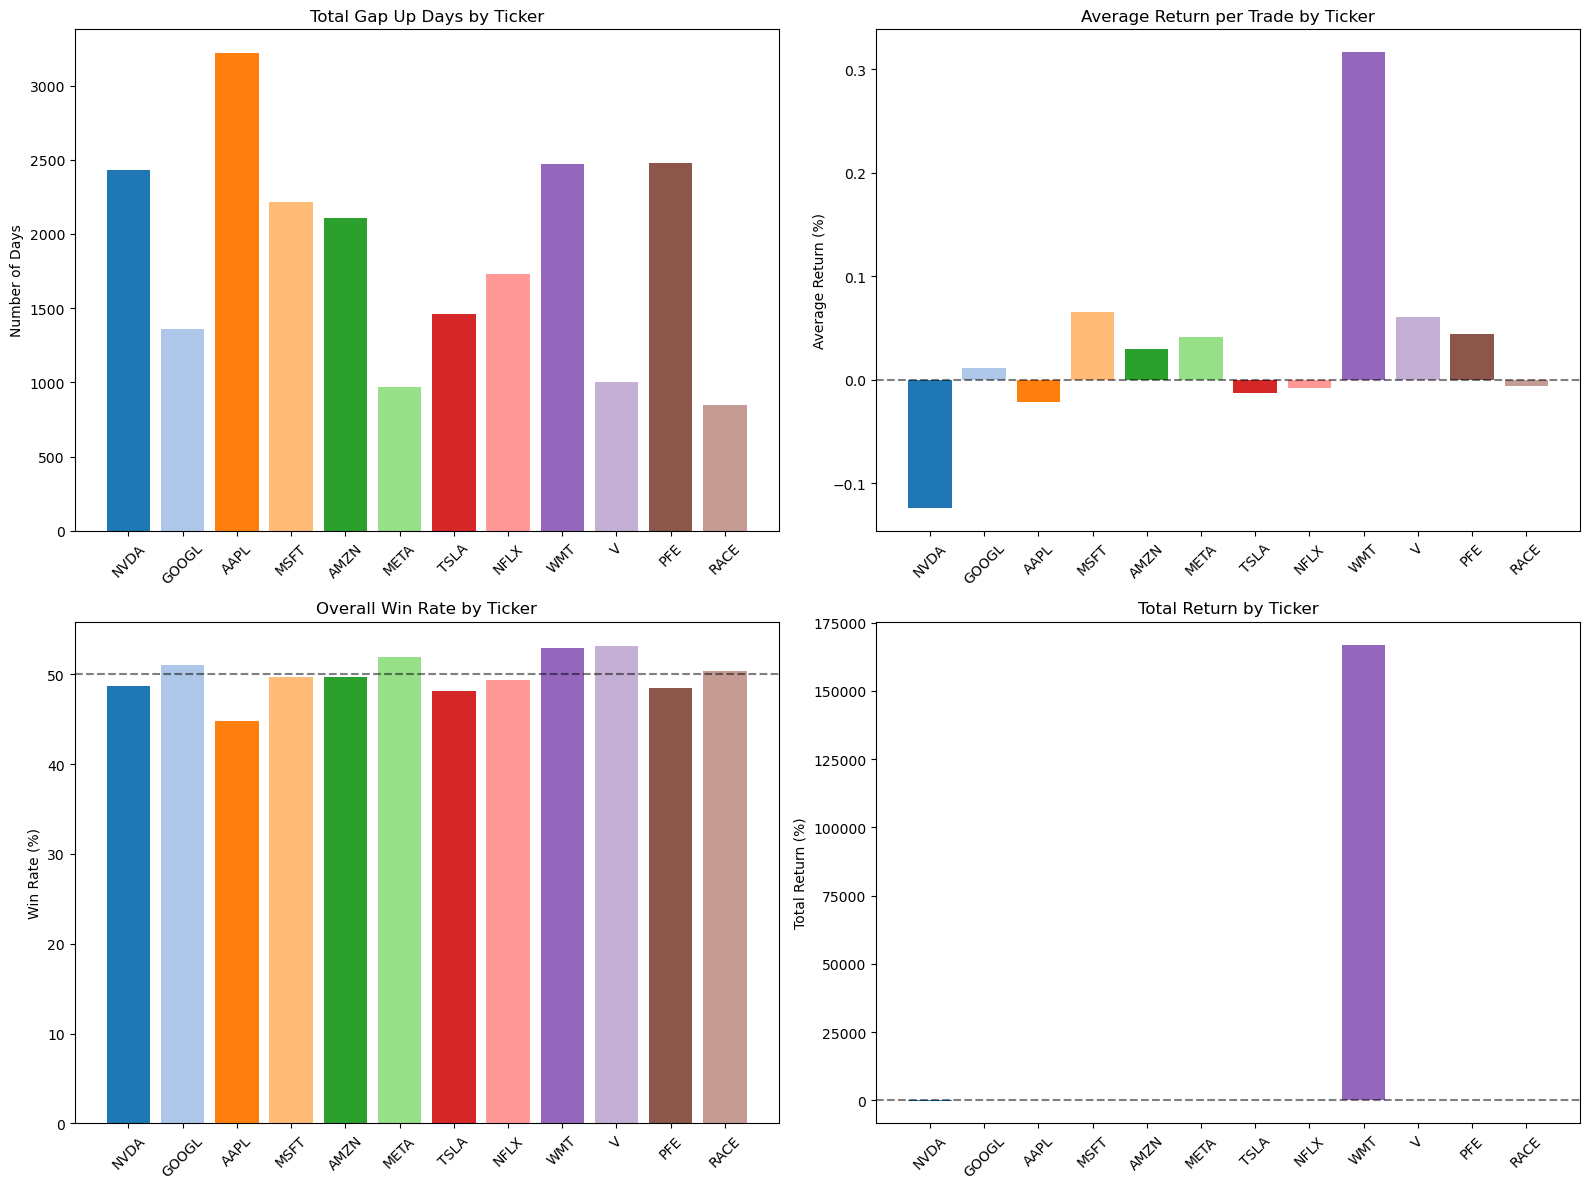


🏆 PERFORMANCE RANKINGS:
--------------------------------------------------
Best Average Return per Trade: WMT (0.3167%)
Best Win Rate: V (53.2%)
Best Total Return: WMT (166971.31%)
Most Trading Opportunities: AAPL (3218 days)
Best Risk-Adjusted Performance: WMT

📊 STRATEGY INSIGHTS:
--------------------------------------------------
• Average gap opportunities per ticker: 1858 days
• Most consistent performer (highest win rate): V
• Highest return potential: WMT
• Ticker with most gap opportunities: AAPL


In [51]:
import matplotlib.pyplot as plt

# Create comprehensive summary comparison
summary_df = pd.DataFrame(all_summaries)
summary_df = summary_df.set_index('Ticker')  # Changed from 'Index' to 'Ticker'

print("\n" + "=" * 100)
print("COMPARATIVE SUMMARY - ALL TICKERS")
print("=" * 100)
print(summary_df)

# Visualization comparing all tickers - dynamic number of subplots
n_tickers = len(summary_df)
n_cols = min(4, n_tickers)  # Max 4 columns
n_rows = 2

fig, axes = plt.subplots(n_rows, 2, figsize=(16, 12))

# Generate colors dynamically
colors = plt.cm.tab20(range(n_tickers))

# 1. Total Gap Up Days comparison
axes[0,0].bar(summary_df.index, summary_df['Total Gap Up Days'], color=colors)
axes[0,0].set_title('Total Gap Up Days by Ticker')
axes[0,0].set_ylabel('Number of Days')
axes[0,0].tick_params(axis='x', rotation=45)

# 2. Average Return per Trade comparison
axes[0,1].bar(summary_df.index, summary_df['Average Return per Trade (%)'], color=colors)
axes[0,1].set_title('Average Return per Trade by Ticker')
axes[0,1].set_ylabel('Average Return (%)')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].axhline(0, color='black', linestyle='--', alpha=0.5)

# 3. Win Rate comparison
axes[1,0].bar(summary_df.index, summary_df['Overall Win Rate (%)'], color=colors)
axes[1,0].set_title('Overall Win Rate by Ticker')
axes[1,0].set_ylabel('Win Rate (%)')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].axhline(50, color='black', linestyle='--', alpha=0.5, label='50% threshold')

# 4. Total Return comparison
axes[1,1].bar(summary_df.index, summary_df['Total Return (%)'], color=colors)
axes[1,1].set_title('Total Return by Ticker')
axes[1,1].set_ylabel('Total Return (%)')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].axhline(0, color='black', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# Best performing ticker analysis
best_avg_return = summary_df['Average Return per Trade (%)'].idxmax()
best_win_rate = summary_df['Overall Win Rate (%)'].idxmax()
best_total_return = summary_df['Total Return (%)'].idxmax()
most_opportunities = summary_df['Total Gap Up Days'].idxmax()

print(f"\n🏆 PERFORMANCE RANKINGS:")
print("-" * 50)
print(f"Best Average Return per Trade: {best_avg_return} ({summary_df.loc[best_avg_return, 'Average Return per Trade (%)']}%)")
print(f"Best Win Rate: {best_win_rate} ({summary_df.loc[best_win_rate, 'Overall Win Rate (%)']}%)")
print(f"Best Total Return: {best_total_return} ({summary_df.loc[best_total_return, 'Total Return (%)']}%)")
print(f"Most Trading Opportunities: {most_opportunities} ({summary_df.loc[most_opportunities, 'Total Gap Up Days']} days)")

# Risk-adjusted performance (Sharpe-like ratio)
summary_df['Risk_Adj_Performance'] = summary_df['Average Return per Trade (%)'] / (summary_df['Average Return per Trade (%)'].std() if summary_df['Average Return per Trade (%)'].std() > 0 else 1)
best_risk_adj = summary_df['Risk_Adj_Performance'].idxmax()
print(f"Best Risk-Adjusted Performance: {best_risk_adj}")

print(f"\n📊 STRATEGY INSIGHTS:")
print("-" * 50)
print(f"• Average gap opportunities per ticker: {summary_df['Total Gap Up Days'].mean():.0f} days")
print(f"• Most consistent performer (highest win rate): {best_win_rate}")
print(f"• Highest return potential: {best_avg_return}")
print(f"• Ticker with most gap opportunities: {most_opportunities}")

AttributeError: 'list' object has no attribute 'items'

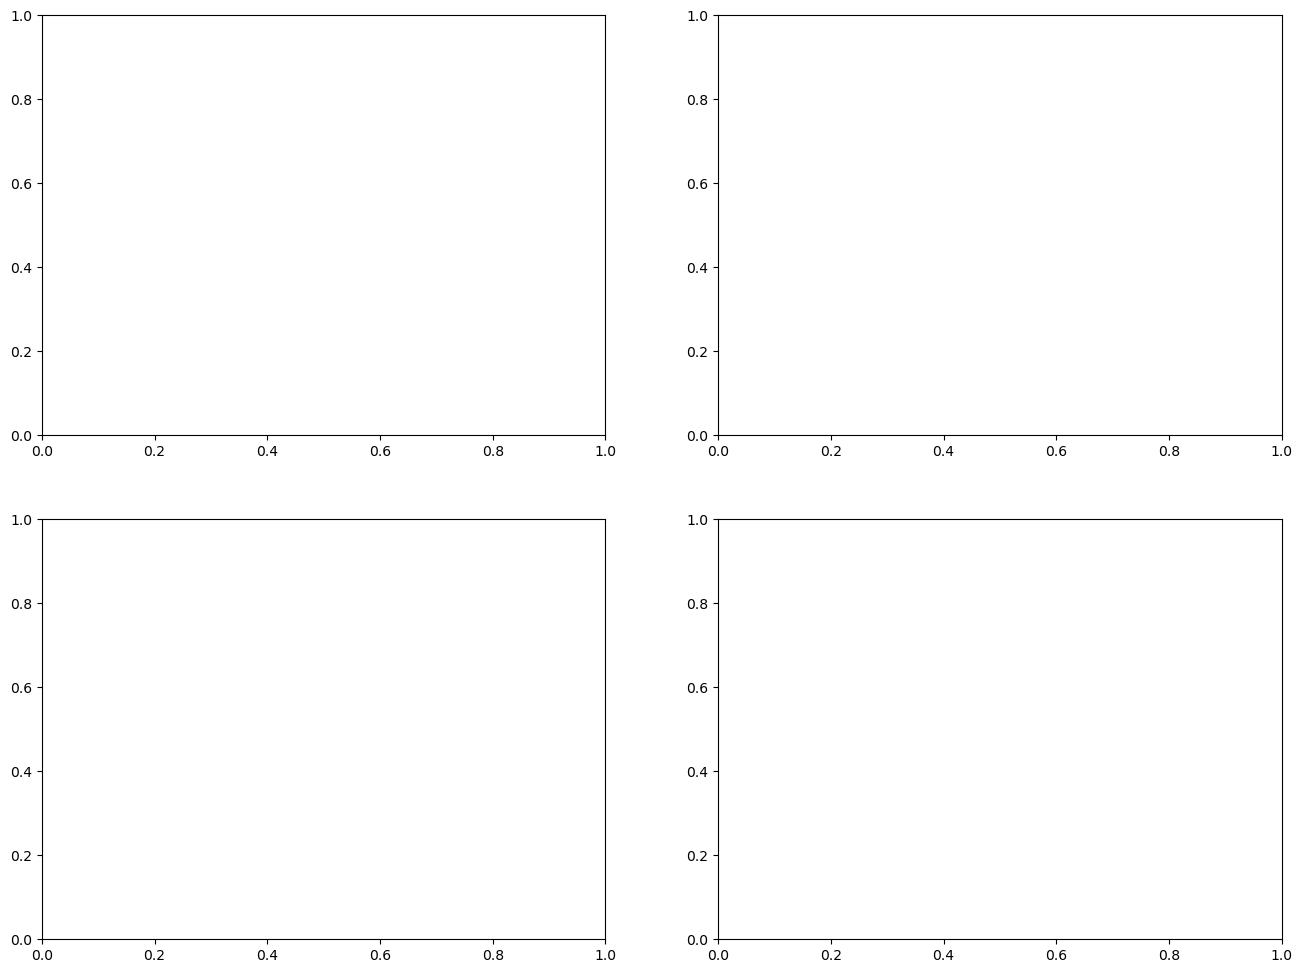

In [52]:
# Plot average returns by day of week for all tickers
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

# Colors for each index
colors = ['blue', 'green', 'red', 'orange']
ticker_names = ['SP500', 'NASDAQ', 'Dow Jones', 'Russell 2000']

for i, (name, data) in enumerate(tickers.items()):
    if name in all_results:
        strategy_results = all_results[name]['strategy_results']
        
        axes[i].bar(strategy_results.index, strategy_results['mean'], 
                   color=colors[i], alpha=0.7)
        axes[i].set_title(f"{ticker_names[i]} - Average Intraday Return by Day of Week")
        axes[i].set_xlabel("Day of Week")
        axes[i].set_ylabel("Average Return (%)")
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].axhline(0, color='black', linestyle='--', alpha=0.5)
        axes[i].grid(True, alpha=0.3)
        
        # Add value labels on bars
        for j, v in enumerate(strategy_results['mean']):
            axes[i].text(j, v + 0.01 if v >= 0 else v - 0.02, f'{v:.3f}%', 
                        ha='center', va='bottom' if v >= 0 else 'top', fontsize=9)

plt.suptitle("Average Gap Up Returns by Day of Week - All Tickers", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

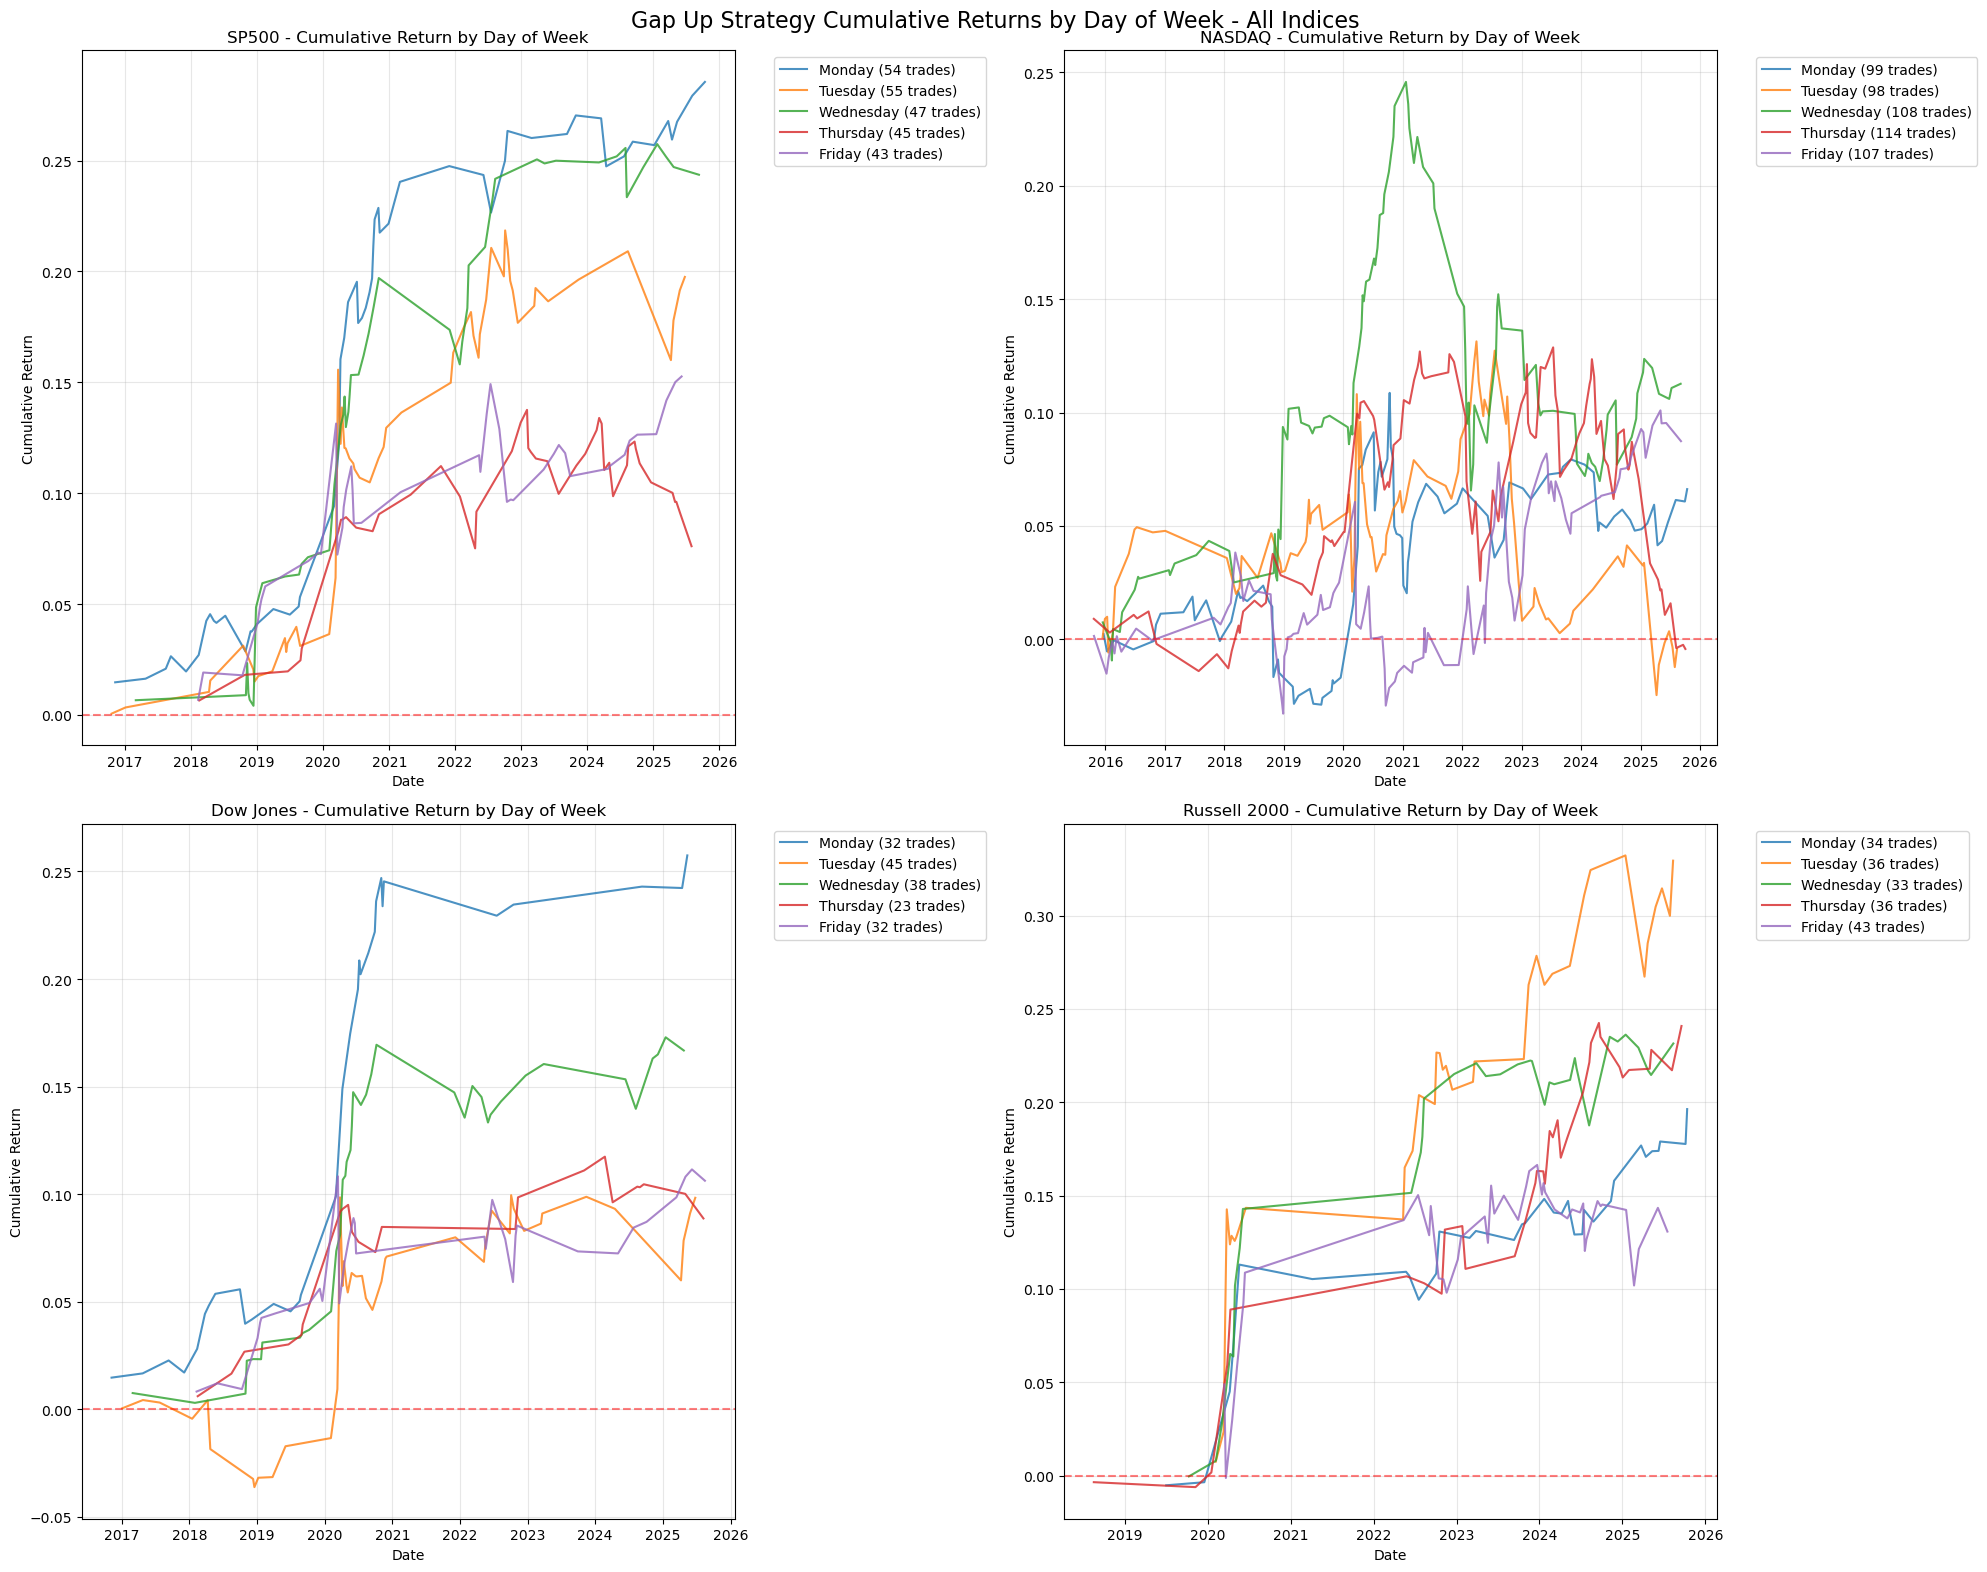

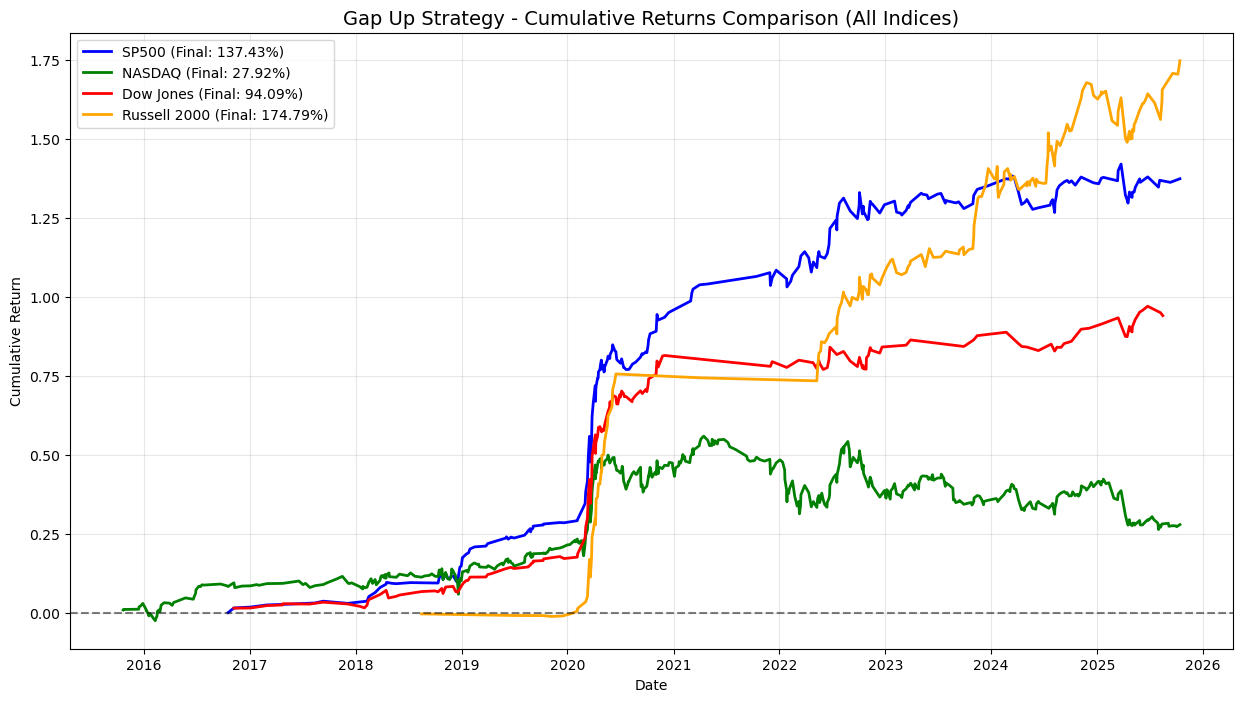

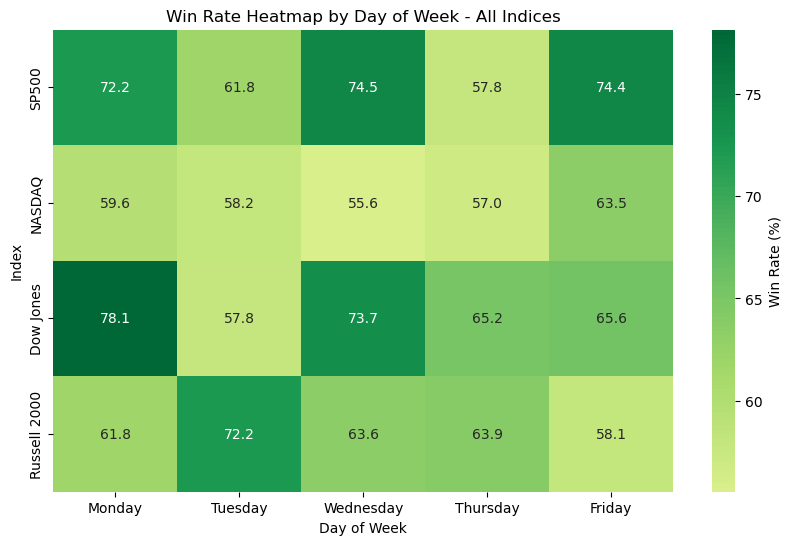

In [ ]:
import seaborn as sns

# Cumulative return plots for all tickers
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
axes = axes.flatten()

day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
colors = ['blue', 'green', 'red', 'orange']
ticker_names = ['SP500', 'NASDAQ', 'Dow Jones', 'Russell 2000']

for i, (name, data) in enumerate(tickers.items()):
    # Filter for gap up days
    gap_up_days_index = data[data['gap_label'] == 1].copy()
    
    if not gap_up_days_index.empty:
        # Calculate intraday return
        gap_up_days_index['intraday_return'] = ((gap_up_days_index['close'] - gap_up_days_index['open']) / gap_up_days_index['open']) * 100
        
        # Plot cumulative return for each day of the week
        for day in range(5):  # Monday to Friday
            day_data = gap_up_days_index[gap_up_days_index['day_of_week'] == day]
            if not day_data.empty:
                day_cumulative = (1 + day_data['intraday_return'] / 100).cumprod() - 1
                axes[i].plot(day_data.index, day_cumulative, 
                           label=f'{day_names[day]} ({len(day_data)} trades)', 
                           linewidth=1.5, alpha=0.8)
        
        axes[i].set_title(f'{ticker_names[i]} - Cumulative Return by Day of Week')
        axes[i].set_xlabel('Date')
        axes[i].set_ylabel('Cumulative Return')
        axes[i].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        axes[i].grid(True, alpha=0.3)
        axes[i].axhline(0, color='red', linestyle='--', alpha=0.5)

plt.suptitle("Gap Up Strategy Cumulative Returns by Day of Week - All Tickers", fontsize=16, y=0.98)
plt.tight_layout()
plt.show()

# Overall cumulative comparison across all tickers
plt.figure(figsize=(15, 8))

for i, (name, data) in enumerate(tickers_.items()):
    gap_up_days_index = data[data['gap_label'] == 1].copy()
    
    if not gap_up_days_index.empty:
        gap_up_days_index['intraday_return'] = ((gap_up_days_index['close'] - gap_up_days_index['open']) / gap_up_days_index['open']) * 100
        cumulative_return = (1 + gap_up_days_index['intraday_return'] / 100).cumprod() - 1
        
        plt.plot(gap_up_days_index.index, cumulative_return, 
                label=f'{ticker_names[i]} (Final: {cumulative_return.iloc[-1]:.2%})', 
                linewidth=2, color=colors[i])

plt.title("Gap Up Strategy - Cumulative Returns Comparison (All Tickers)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True, alpha=0.3)
plt.axhline(0, color='black', linestyle='--', alpha=0.5)
plt.show()

# Win rate comparison heatmap
win_rate_data = []
for name, data in tickers_.items():
    if name in all_results:
        win_rates = all_results[name]['win_rates']
        win_rate_data.append([win_rates.get(day, 0) for day in day_names[:5]])  # Monday to Friday only

win_rate_df = pd.DataFrame(win_rate_data, 
                          index=ticker_names, 
                          columns=day_names[:5])

plt.figure(figsize=(10, 6))
sns.heatmap(win_rate_df, annot=True, cmap='RdYlGn', center=50, 
            fmt='.1f', cbar_kws={'label': 'Win Rate (%)'})
plt.title("Win Rate Heatmap by Day of Week - All Tickers")
plt.xlabel("Day of Week")
plt.ylabel("Index")
plt.show()

In [ ]:
"""
add here cumulative return plots for all tickers
""";

'\nadd here cumulative return plots for all indices\n'

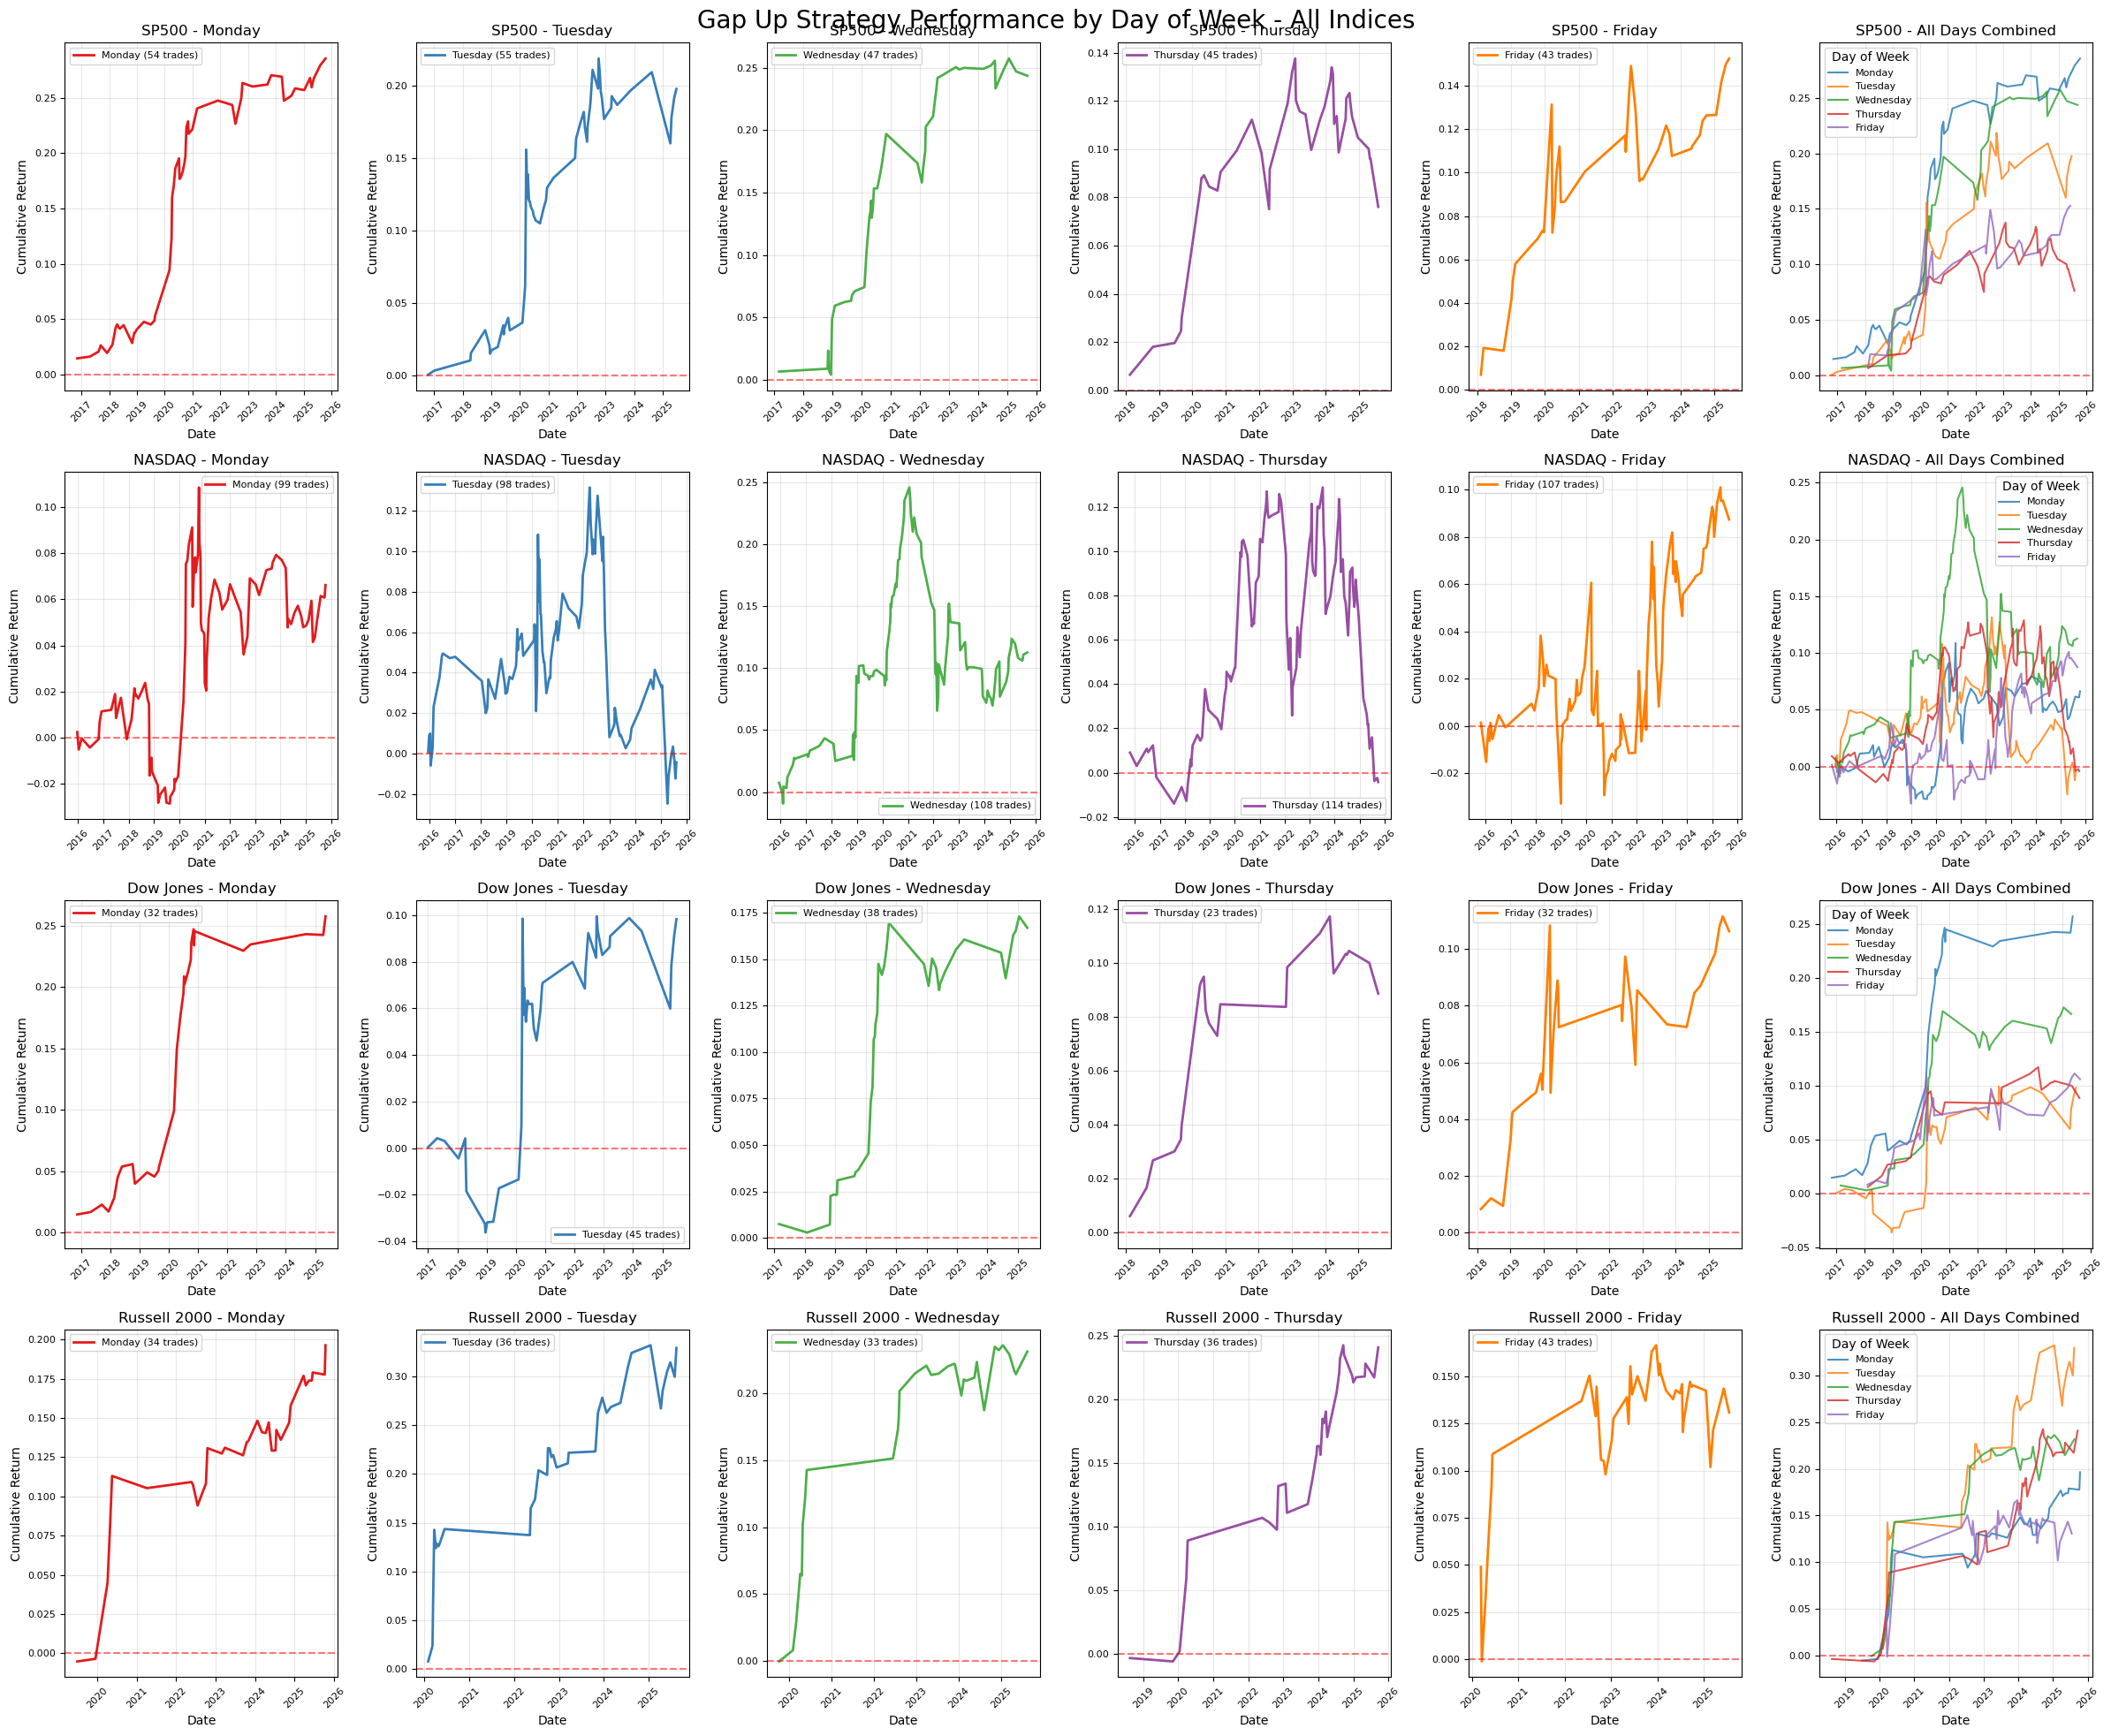


DETAILED PERFORMANCE BY INDEX AND DAY OF WEEK
       Index       Day  Trades  Avg_Return_%  Total_Return_%  Win_Rate_%  Best_Return_%  Worst_Return_%  Std_Dev_%
       SP500    Monday      54        0.4713           25.45       72.22         3.8984         -1.7059     1.0407
       SP500   Tuesday      55        0.3377           18.58       61.82         4.3887         -4.0589     1.3926
       SP500 Wednesday      47        0.4709           22.13       74.47         4.4255         -1.9505     1.1109
       SP500  Thursday      45        0.1702            7.66       57.78         5.1485         -2.1276     1.2102
       SP500    Friday      43        0.3422           14.71       74.42         5.4876         -5.2230     1.5185
      NASDAQ    Monday      99        0.0705            6.97       59.60         3.3037         -3.1601     1.0664
      NASDAQ   Tuesday      98        0.0052            0.51       58.16         3.7158         -5.6432     1.3797
      NASDAQ Wednesday     108   

In [ ]:
# Comprehensive day-of-week analysis for each ticker (similar to cell 13 structure)
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
ticker_names = ['SP500', 'NASDAQ', 'Dow Jones', 'Russell 2000']

# Create a large figure with subplots for each ticker
fig = plt.figure(figsize=(24, 20))

# Counter for subplot positioning
subplot_counter = 1

for idx, (name, data) in enumerate(tickers_.items()):
    # Filter for gap up days for this ticker
    gap_up_days_index = data[data['gap_label'] == 1].copy()
    
    if not gap_up_days_index.empty:
        # Calculate intraday return
        gap_up_days_index['intraday_return'] = ((gap_up_days_index['close'] - gap_up_days_index['open']) / gap_up_days_index['open']) * 100
        
        # Create 2x3 subplots for each ticker (5 weekdays + 1 combined)
        for day in range(6):  # 0-4 for weekdays, 5 for combined
            ax = plt.subplot(4, 6, subplot_counter)
            
            if day < 5:  # Individual weekdays
                day_data = gap_up_days_index[gap_up_days_index['day_of_week'] == day]
                if not day_data.empty:
                    # Calculate separate cumulative return for this day only
                    day_cumulative = (1 + day_data['intraday_return'] / 100).cumprod() - 1
                    
                    ax.plot(day_data.index, day_cumulative, 
                           label=f'{day_names[day]} ({len(day_data)} trades)', 
                           linewidth=2, color=plt.cm.Set1(day))
                    ax.set_title(f'{ticker_names[idx]} - {day_names[day]}')
                    ax.set_xlabel('Date')
                    ax.set_ylabel('Cumulative Return')
                    ax.legend(fontsize=8)
                    ax.grid(True, alpha=0.3)
                    ax.axhline(0, color='red', linestyle='--', alpha=0.5)
                    
                    # Format x-axis for better readability
                    ax.tick_params(axis='x', rotation=45, labelsize=8)
                    ax.tick_params(axis='y', labelsize=8)
                else:
                    ax.text(0.5, 0.5, f'No {day_names[day]}\ngap-up days', 
                           ha='center', va='center', transform=ax.transAxes)
                    ax.set_title(f'{ticker_names[idx]} - {day_names[day]}')
            
            else:  # Combined plot (day == 5)
                ax.set_title(f'{ticker_names[idx]} - All Days Combined')
                for weekday in range(5):  # Monday to Friday
                    day_data = gap_up_days_index[gap_up_days_index['day_of_week'] == weekday]
                    if not day_data.empty:
                        day_cumulative = (1 + day_data['intraday_return'] / 100).cumprod() - 1
                        ax.plot(day_data.index, day_cumulative, 
                               label=f'{day_names[weekday]}', linewidth=1.5, alpha=0.8)
                
                ax.set_xlabel('Date')
                ax.set_ylabel('Cumulative Return')
                ax.legend(title="Day of Week", fontsize=8)
                ax.grid(True, alpha=0.3)
                ax.axhline(0, color='red', linestyle='--', alpha=0.5)
                ax.tick_params(axis='x', rotation=45, labelsize=8)
                ax.tick_params(axis='y', labelsize=8)
            
            subplot_counter += 1

plt.suptitle("Gap Up Strategy Performance by Day of Week - All Tickers", fontsize=20, y=0.98)
plt.tight_layout()
plt.show()

# Summary statistics table for each ticker and day combination
print("\n" + "=" * 120)
print("DETAILED PERFORMANCE BY TICKER AND DAY OF WEEK")
print("=" * 120)

summary_table = []
for name, data in tickers_.items():
    gap_up_days_index = data[data['gap_label'] == 1].copy()
    
    if not gap_up_days_index.empty:
        gap_up_days_index['intraday_return'] = ((gap_up_days_index['close'] - gap_up_days_index['open']) / gap_up_days_index['open']) * 100
        
        for day in range(5):  # Monday to Friday
            day_data = gap_up_days_index[gap_up_days_index['day_of_week'] == day]
            if not day_data.empty:
                day_stats = {
                    'Ticker': name,
                    'Day': day_names[day],
                    'Trades': len(day_data),
                    'Avg_Return_%': round(day_data['intraday_return'].mean(), 4),
                    'Total_Return_%': round(day_data['intraday_return'].sum(), 2),
                    'Win_Rate_%': round((day_data['intraday_return'] > 0).sum() / len(day_data) * 100, 2),
                    'Best_Return_%': round(day_data['intraday_return'].max(), 4),
                    'Worst_Return_%': round(day_data['intraday_return'].min(), 4),
                    'Std_Dev_%': round(day_data['intraday_return'].std(), 4)
                }
                summary_table.append(day_stats)

detailed_df = pd.DataFrame(summary_table)
print(detailed_df.to_string(index=False))

# Find best performing day-index combinations
print(f"\n BEST PERFORMING COMBINATIONS:")
print("-" * 60)
best_avg = detailed_df.loc[detailed_df['Avg_Return_%'].idxmax()]
best_total = detailed_df.loc[detailed_df['Total_Return_%'].idxmax()]
best_winrate = detailed_df.loc[detailed_df['Win_Rate_%'].idxmax()]
most_trades = detailed_df.loc[detailed_df['Trades'].idxmax()]

print(f"Best Average Return: {best_avg['Ticker']} on {best_avg['Day']} ({best_avg['Avg_Return_%']}%)")
print(f"Best Total Return: {best_total['Ticker']} on {best_total['Day']} ({best_total['Total_Return_%']}%)")
print(f"Best Win Rate: {best_winrate['Ticker']} on {best_winrate['Day']} ({best_winrate['Win_Rate_%']}%)")
print(f"Most Trading Opportunities: {most_trades['Ticker']} on {most_trades['Day']} ({most_trades['Trades']} trades)")